-------------------------------------
> ***Name:*** Mubanga Nsofu <br>
> ***Learner Id:*** 149050 <br>
> ***Course:*** BAN6800 (Business Analytics Capstone) <br>
> ***Assignment Four:*** Business Analytics Model <br>
> ***Lecturer:*** Professor Raphael Wanjiku <br>
> ***Institution:*** Nexford University <br>
> ***Date:*** 30th May 2025

-------------------------------------------
> ***INTRODUCTION*** <br>

> This notebook implements an unsupervised learning model, k-Means (MacQueen, 1967) to help Takealot find behavioural segments amongst segment customers. The algorithm implemented in python will help Takealot take actionable recommendations based on a better understanding of customer behaviour. This will ultimately help Takealot compete better in South Africa.<br/>
The code below implements an Unsupervised Learning Pipeline for Customer Behavior Segmentation for Takealot


--------------
***IMPORT LIBRARIES***

In [2]:
'''Main'''
import pandas as pd
import numpy as np

'''Algorithms and tools'''
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import  homogeneity_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.utils import resample 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import davies_bouldin_score

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
# For inline plotting
%matplotlib inline


------------------
***LOAD DATASET FROM MILESTONE ONE***

In [3]:
data_frame = pd.read_csv('online_shoppers_Intention_cleaned.csv')

--------------
***DISPLAY THE FIRST FEW ROWS OF THE DATASET & BASIC INFORMATION***



In [4]:
data_frame.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,VisitorType_Other,VisitorType_Returning_Visitor,Total_Duration,Interaction_Intensity
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,-1.665924,-1.233426,-0.790293,-0.894178,-0.762629,-0.550552,0,-0.083316,0.410621,-0.642894,-0.113505
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,-1.665924,-0.136078,-0.207952,-0.894178,-0.514182,-0.550552,0,-0.083316,0.410621,-0.611486,-0.113505
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,-1.665924,2.058618,-0.790293,2.437081,-0.265735,-0.550552,0,-0.083316,0.410621,-0.642894,-0.113505
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,-0.308821,-1.665924,0.961270,-0.207952,-0.477771,-0.017289,-0.550552,0,-0.083316,0.410621,-0.641585,-0.113505
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,-0.308821,-1.665924,0.961270,0.374389,-0.894178,-0.017289,1.816360,0,-0.083316,0.410621,-0.334952,-0.113505


In [5]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Administrative                 12330 non-null  float64
 1   Administrative_Duration        12330 non-null  float64
 2   Informational                  12330 non-null  float64
 3   Informational_Duration         12330 non-null  float64
 4   ProductRelated                 12330 non-null  float64
 5   ProductRelated_Duration        12330 non-null  float64
 6   BounceRates                    12330 non-null  float64
 7   ExitRates                      12330 non-null  float64
 8   PageValues                     12330 non-null  float64
 9   SpecialDay                     12330 non-null  float64
 10  Month                          12330 non-null  float64
 11  OperatingSystems               12330 non-null  float64
 12  Browser                        12330 non-null 

-------------------
***SELECT FEATURES FOR CLUSTERING***

> Revenue is the target variable and the goal is to discover natural groupings or patterns in the dataset without using labels.
> Including Revenue would bias the clustering as the algorithm would try to group based on purchase outcome and thus make the clustering artificially driven by the answer



In [6]:
X = data_frame.drop(columns=['Revenue'])
print(X)

       Administrative  Administrative_Duration  Informational  ...  VisitorType_Returning_Visitor  Total_Duration  Interaction_Intensity
0           -0.696993                -0.457191      -0.396478  ...                       0.410621       -0.642894              -0.113505
1           -0.696993                -0.457191      -0.396478  ...                       0.410621       -0.611486              -0.113505
2           -0.696993                -0.457191      -0.396478  ...                       0.410621       -0.642894              -0.113505
3           -0.696993                -0.457191      -0.396478  ...                       0.410621       -0.641585              -0.113505
4           -0.696993                -0.457191      -0.396478  ...                       0.410621       -0.334952              -0.113505
...               ...                      ...            ...  ...                            ...             ...                    ...
12325        0.206173                 0.3

--------------------
***DIMENSIONALITY REDUCTION***

> Before performing clustering, the dimensionality of the data will be reduced using PCA. PCA, a dimensionality reduction algorithm, captures the salient information in the original data while reducing the size of the dataset. The noise in the dataset is minimized because the dimensionality reduction algorithm (PCA) captures the most important aspects of the original data and does not devote attention to infrequently occurring elements (such as the noise in the dataset).

In [7]:
pca = PCA(n_components=0.70, random_state=42) # Retain at least 70% of the variance
X_pca = pca.fit_transform(X)


In [8]:
print(X_pca)

[[-3.01514482  3.85363513  0.58383062 ... -0.85542363  0.01035921
  -0.1567858 ]
 [-1.64088296  0.84242168 -0.67093047 ... -0.26636369 -0.62445643
  -0.61063059]
 [-3.13571147  2.72157899  2.74640274 ... -1.00930761  0.26154123
   2.27989725]
 ...
 [-1.64644777  0.45181493  1.37867456 ...  1.82626199  1.81227199
  -1.1457265 ]
 [-0.32081181 -0.6508767   0.06130546 ... -0.39780325  0.28429011
  -0.82477969]
 [-1.25321925 -1.32150684 -0.27890544 ...  1.70302428  0.92831902
  -0.64764268]]


--------------------
***KMEANS ALGORITHM***

>The objective of clustering is to identify distinct groups in a dataset such that the observations within a group are similar to each other but different from observations in other groups. <br/> In k-means clustering, we specify the number of desired clusters k, and the algorithm will assign each observation to exactly one of these k clusters. The algorithm optimizes the groups by minimizing the within-cluster variation (also known as inertia) such that the sum of the within-cluster variations across all k clusters is as small as possible.



----------------
***FIRST WE DETERMINE OPTIMAL NUMBER OF CLUSTERS USING THE CALINSKI-HARABASZ METHOD***

> During the search for an optimal number of clusters, I encountered memory errors, specifically MemoryError: *Unable to allocate 1.00 GiB for an array with shape (10885, 12330) and data type float64*. To solve the issue, I resorted to using the calinski-harabasz method instead of the Silhouette Method.


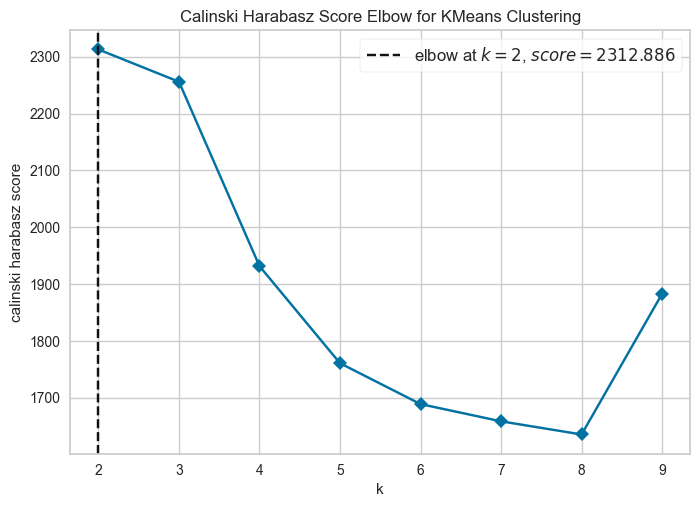

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [9]:
#Elbow Method to Find Optimal k
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10), metric='calinski_harabasz', timings=False)
visualizer.fit(X_pca)
visualizer.show()

> The chart above shows the optimal value for k to be 2. The higher the Calinski-Harabasz score the better.

--------------------
***BEHAVIORAL SEGMENTATION MODELING USING KMEANS***

In [10]:
# Final Clustering with Optimal k =2
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X_pca)

In [11]:
#Add Cluster Labels to Data
X_clustered = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
X_clustered['Cluster'] = labels
X_clustered['Revenue'] = data_frame['Revenue'].values

----------------
***VISUALIZE CLUSTER SEPARATION***

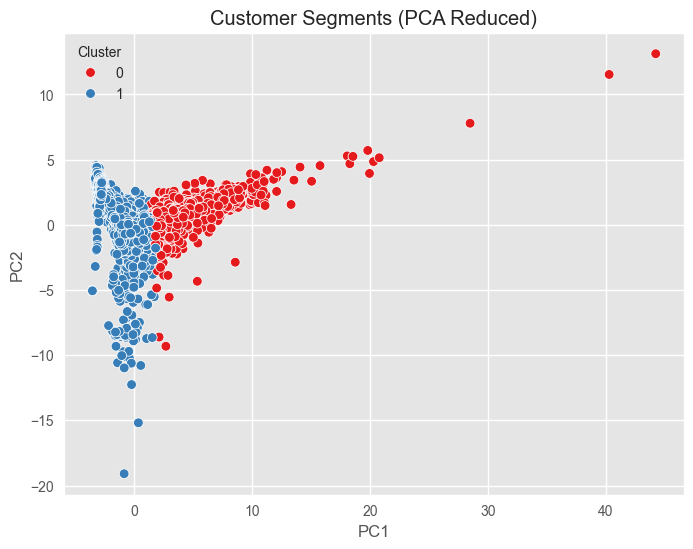

In [12]:
#Visualize Cluster Separation
# Use ggplot style adapated from R (Hadley Wickam)
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=X_clustered, palette='Set1')
plt.title('Customer Segments (PCA Reduced)')
plt.show()

-------------------
***CLUSTER PROFILING AND INTERPRETATION***

In [13]:
cluster_profiles = data_frame.copy()
cluster_profiles['Cluster'] = labels
print(cluster_profiles.groupby('Cluster').mean())

         Administrative  Administrative_Duration  Informational  \
Cluster                                                           
0              1.372850                 1.191903       1.423892   
1             -0.220752                -0.191656      -0.228959   

         Informational_Duration  ProductRelated  ProductRelated_Duration  \
Cluster                                                                    
0                      1.154814        1.532017                 1.489285   
1                     -0.185692       -0.246346                -0.239475   

         BounceRates  ExitRates  PageValues  SpecialDay  ...  \
Cluster                                                  ...   
0          -0.329692  -0.486804    0.201139   -0.172245  ...   
1           0.053014   0.078277   -0.032343    0.027697  ...   

         OperatingSystems   Browser    Region  TrafficType   Weekend  \
Cluster                                                                
0               -0.022360

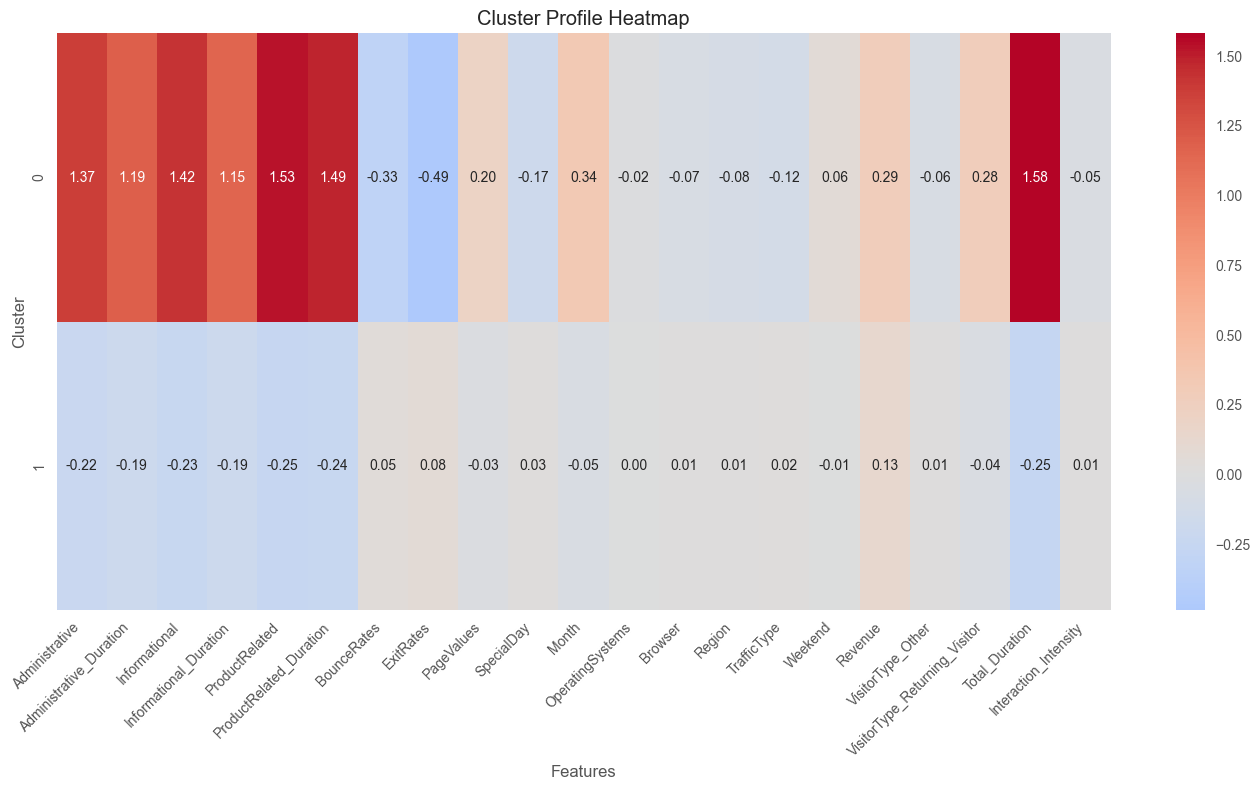

In [20]:
# Visualise the cluster profile

cluster_profile = cluster_profiles.groupby('Cluster').mean()

plt.figure(figsize=(14, 8))
sns.heatmap(cluster_profile, annot=True, fmt=".2f", cmap="coolwarm", center=0)

plt.title("Cluster Profile Heatmap")
plt.xlabel("Features")
plt.ylabel("Cluster")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

> Cluster 0 has high intent shoppers/likely buyers. They exhibit strong engagement  with high values in ProductRelated, ProductRelated_Duration, Administrative etc <br/> they tend to stay long on the site and have a high Total_Duration ***(+1.58)*** <br/> They have low bounce/exit rates which are significantly negative. They also have more returning users(***VistorType_Returning_Visitor = +0.28)*** <br/> higher probability of revenue (conversions) ***+0.29***, potential buyers. Users in this cluster are more likely to browse deeply , interact more and convert.

> Cluster 1 has low intent or casual visitors. They have lower engagement KPIs accross various variables: Low page visits and durations (which are both negative) and have a slightly positive bounce rate and exit rates, thus are more inclined to leave quickly. They have slightly more VisitorType_Other and exhibit low revenue (+0.13). Users in this cluster are potentially window shoppers or new users not yet ready to convert. <br/> > The heatmap will be used by stakeholders to Interpret behaviors per segment and guide personalized marketing. 

---------------------------
***EVALUATE THE CLUSTERING***
> Use  Davies-Bouldin Score To Evaluate The Quality Of Clustering

In [16]:
print("\n--- Clustering Evaluation ---")
davies_score = davies_bouldin_score(X_pca, labels)
print(f"Davies-Bouldin Score: {davies_score:.4f}")


--- Clustering Evaluation ---
Davies-Bouldin Score: 1.5774


> The aim of the model is behavioral segmentation and so a Davies-Bouldin score of 1.5774 is acceptable, the clusters are reasonably distinct and thus the score is good enough for behavoral insights such as tailored marketing campaigns or cross selling etc.

------------------
***SAVE THE CLUSTERED DATASET***

In [24]:
# Save Clustered Dataset for Stakeholders
cluster_profiles.to_csv("online_shoppers_clustered.csv", index=False)



-----------------
***SAVE THE K-Means MODEL***

In [11]:
import joblib
joblib.dump(kmeans, 'kmeans_model.pkl')


['kmeans_model.pkl']

------------
***REFERENCES*** <br>

> MacQueen, J. B. (1967). Some methods for classification and analysis of multivariate observations. In L. M. Le Cam & J. Neyman (Eds.), Proceedings of the Fifth Berkeley Symposium on Mathematical Statistics and Probability (Vol. 1, pp. 281–297). University of California Press. https://projecteuclid.org/euclid.bsmsp/1200512992

> Sakar, C. O., Polat, S. O., Katircioglu, M., & Kastro, Y. (2019). Real-time prediction of online shoppers’ purchasing intention using multilayer perceptron and LSTM recurrent neural networks. Neural Computing and Applications, 31(10), 6893–6908. https://doi.org/10.1007/s00521-018-3523-0